In [1]:
from scipy.io import loadmat
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import numpy as np

def preprocess_data(data, window_size=int(15*7.5), threshold_multiplier=2, end_threshold_multiplier=0.5):
    """
    Preprocesses the input data using the modified method.

    Parameters:
        data (numpy.ndarray): Input time series data.
        window_size (int): Size of the window in seconds for baseline calculation.
        threshold_multiplier (float): Multiplier for standard deviation to identify significant transients.
        end_threshold_multiplier (float): Multiplier for standard deviation to identify the end of transients.

    Returns:
        numpy.ndarray: Preprocessed data.
    """
    num_samples, num_cells = data.shape
    preprocessed_data = np.zeros((num_samples, num_cells))
    
    windows_processed_data = []
    
    for i in range(0, num_samples, window_size):
        window_data = data[i:i + window_size, :]
        
        # Calculate baseline as the 8th percentile within the window
        baseline = np.percentile(window_data, 8, axis=0)
        
        # Handle case where baseline is 0 to prevent division by zero
        # baseline[baseline == 0] = 1
        
        # Normalize cell trace by subtracting the baseline
        normalized_data = window_data - baseline.reshape(1, -1)
        
        # Store processed data for this window
        windows_processed_data.append(normalized_data)
    
    normalized_data = np.vstack(windows_processed_data)
    # Identify significant transients for the entire trace of each cell
    start_condition = normalized_data > threshold_multiplier * np.std(normalized_data, axis=0)
    end_condition = normalized_data < -end_threshold_multiplier * np.std(normalized_data, axis=0)
    # significant_events = start_condition & end_condition

    # # Set fluorescence outside of significant events to 0
    # preprocessed_data = np.where(significant_events, normalized_data, 0)

    # Combine start and end conditions to identify significant events
    significant_events = np.zeros_like(normalized_data)
    event_started = False
    
    for j in range(num_cells):
        for t in range(normalized_data.shape[0]):
            if start_condition[t, j]:
                event_started = True
            if event_started:
                significant_events[t, j] = 1
            if end_condition[t, j] and event_started:
                event_started = False
    
    # Set fluorescence outside of significant events to 0
    preprocessed_data = np.where(significant_events, normalized_data, 0)
    
    
    return preprocessed_data


In [3]:
# link: https://figshare.com/articles/dataset/Data_from_Method_of_place_cell_classification_determines_the_population_of_cells_identified/13560548
import os 

pths = [r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\NikNak_20190827\NikNak_20190827",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Popchips_20190827\Popchips_20190827",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Cheeto_20190830\Cheeto_20190830",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Cheeto_20190829\Cheeto_20190829",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\NikNak_20190826\NikNak_20190826",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Popchips_20190827_1\Popchips_20190827_1",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Voltorb_20190828\Voltorb_20190828",
        r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Voltorb_20190829\Voltorb_20190829",]        

stacked_F = []
stacked_spks = []

for pth in pths:
    loco_path = os.path.join(pth, 'locomotion.mat')
    print(loco_path)
    loco = loadmat(loco_path)
    loco = loco['loco'] * 200

    fall_path = os.path.join(pth, 'Fall.mat')
    fall = loadmat(fall_path)
    fall.keys()

    F = fall['F']
    Fneu = fall['Fneu']
    spks = fall['spks']
    iscell = fall['iscell']
    valid_ids = np.where(iscell[:,0]==1)[0]
    valid_probs = np.where(iscell[:,1]>0.5)[0]
    valid_ids = np.array(valid_ids, dtype=int)
    valid_probs = np.array(valid_probs, dtype=int)
    valid_ids = [x for x in valid_ids if x in valid_probs]

    F = F[valid_ids,:]
    Fneu = Fneu[valid_ids,:]
    spks = spks[valid_ids,:]
    F = F - 0.7*Fneu
    # for i in range(len(spks)):
        # cpy = np.zeros(spks[i].shape)
        # cpy[spks[i]>2.5*np.std(spks[i, :])] = 1 
        # spks[i] = cpy

    F = preprocess_data(F)


    stacked_F.append(F[:, :19999])
    stacked_spks.append(spks[:, :19999])

F = np.vstack(stacked_F)
spks = np.vstack(stacked_spks)


C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\NikNak_20190827\NikNak_20190827\locomotion.mat
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Popchips_20190827\Popchips_20190827\locomotion.mat
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Cheeto_20190830\Cheeto_20190830\locomotion.mat
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Cheeto_20190829\Cheeto_20190829\locomotion.mat
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\NikNak_20190826\NikNak_20190826\locomotion.mat
C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit_test_data\FrontiersRemappingData\HC\Popchips_20190827_1\Popchips_20190827_1\locomotion.mat
C:\Users\aaoun\OneDrive - cumc.col

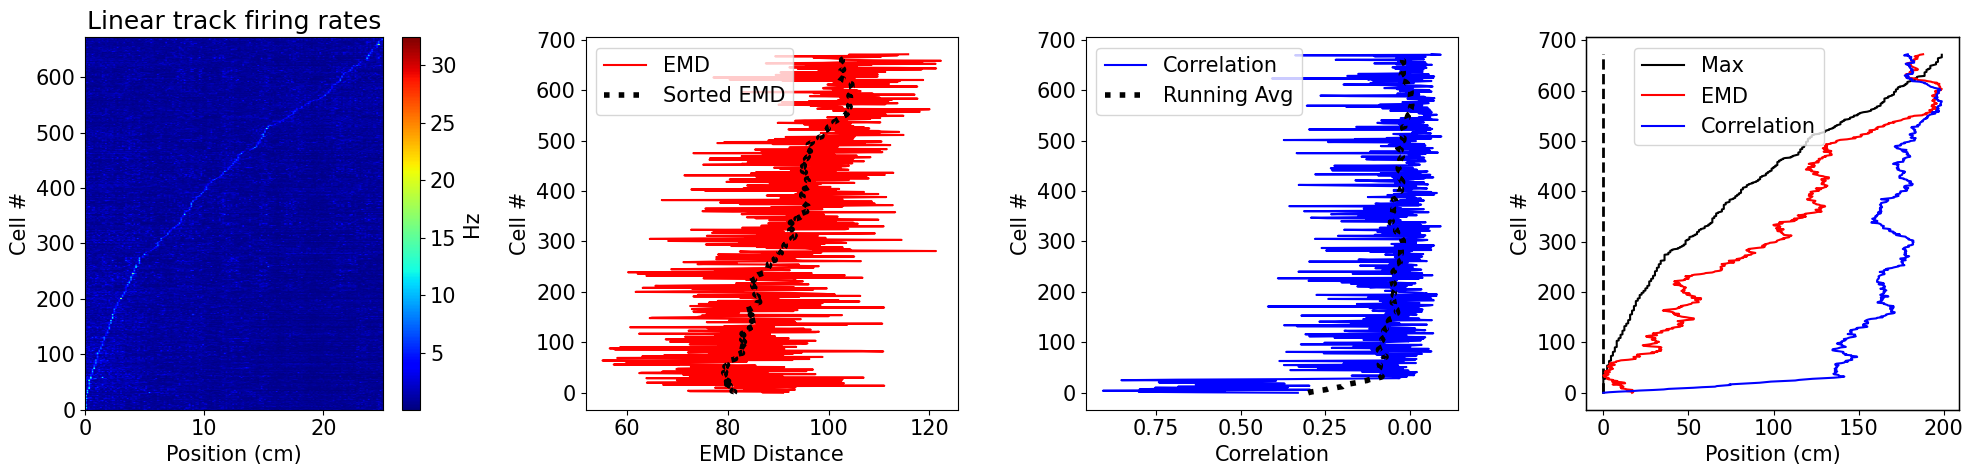

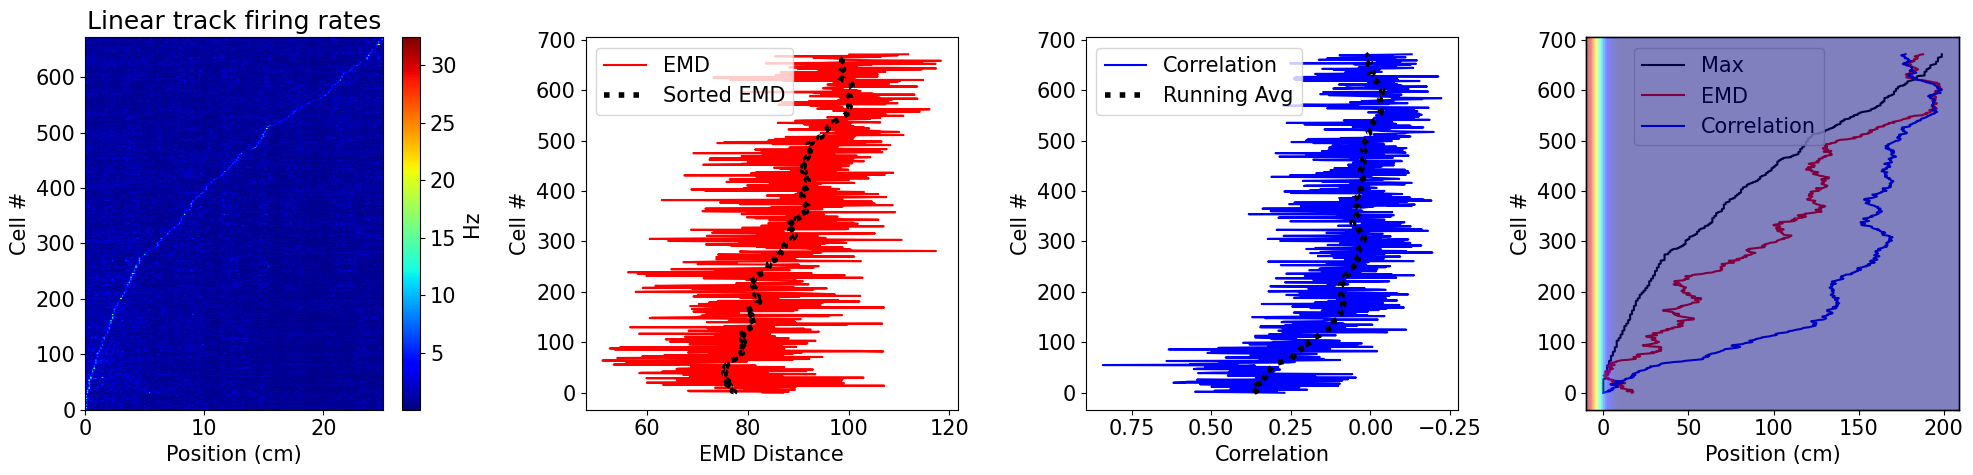

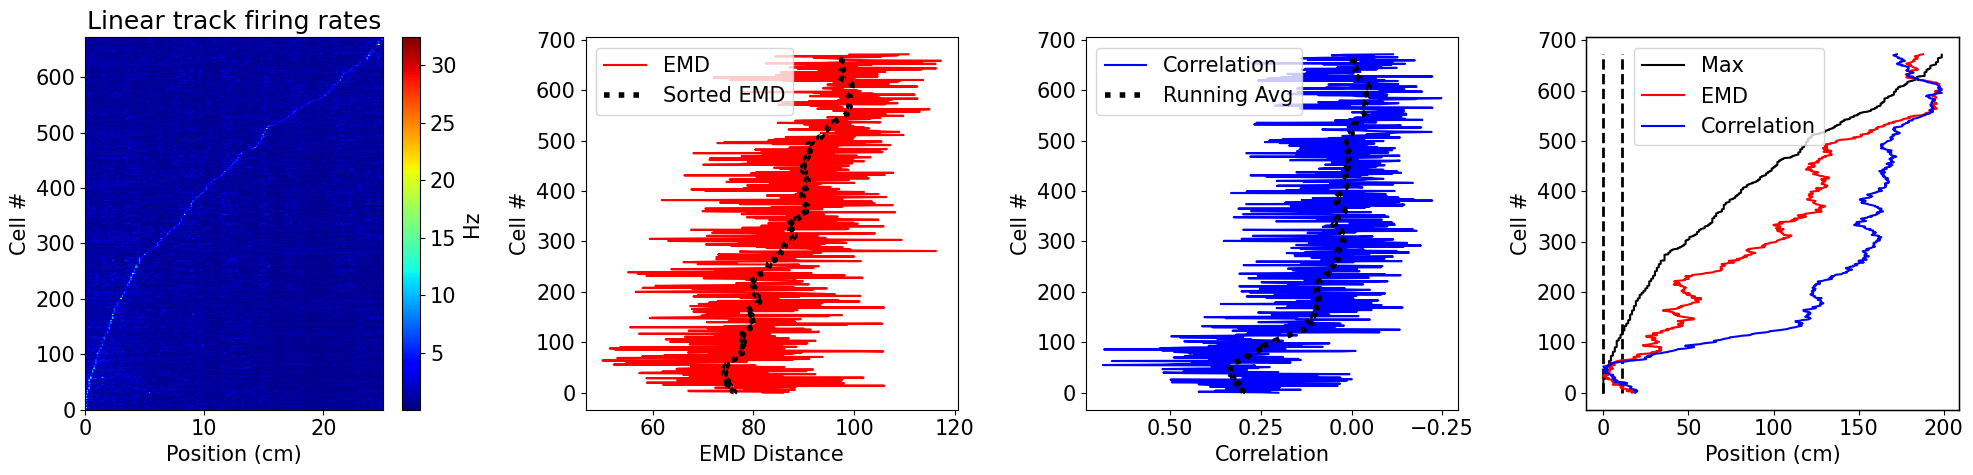

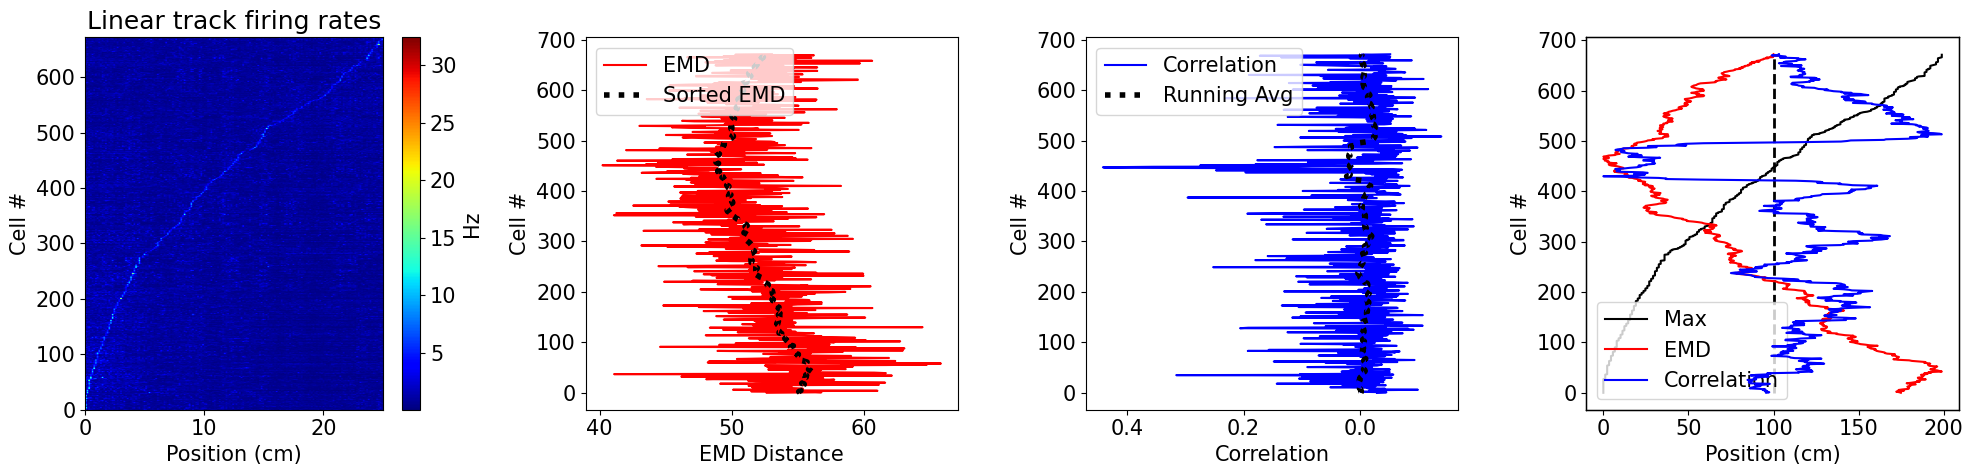

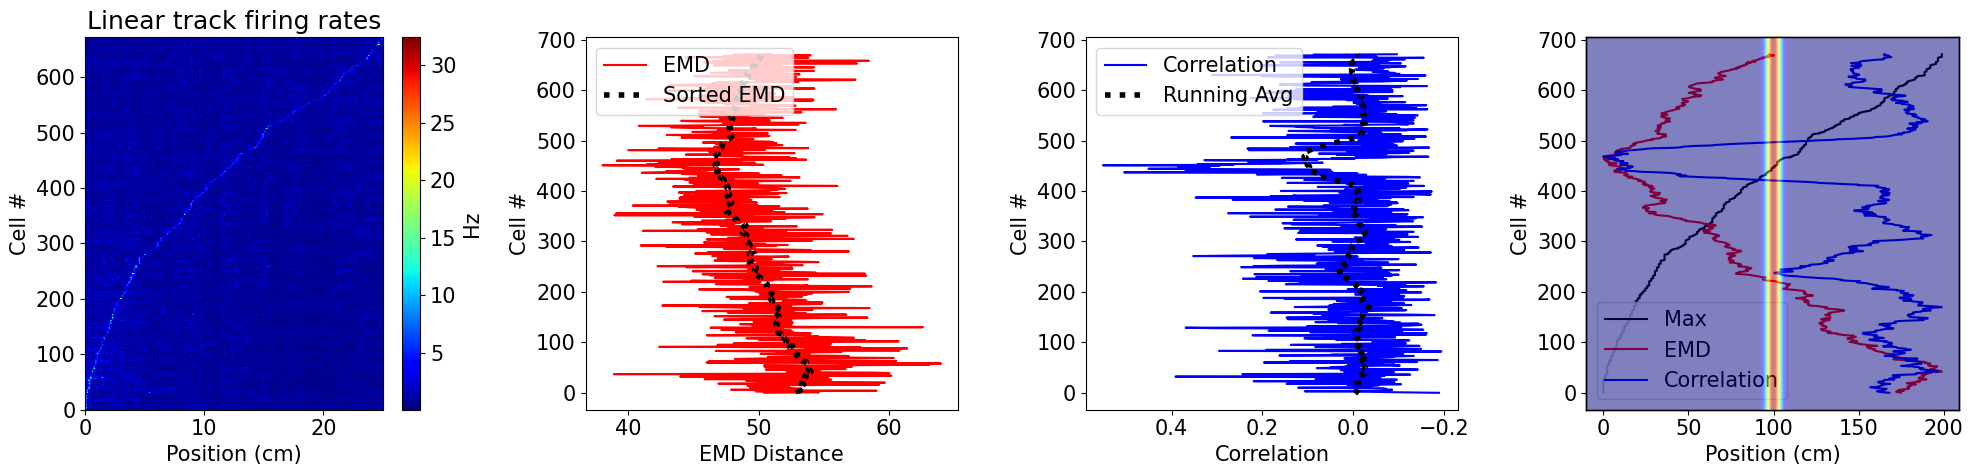

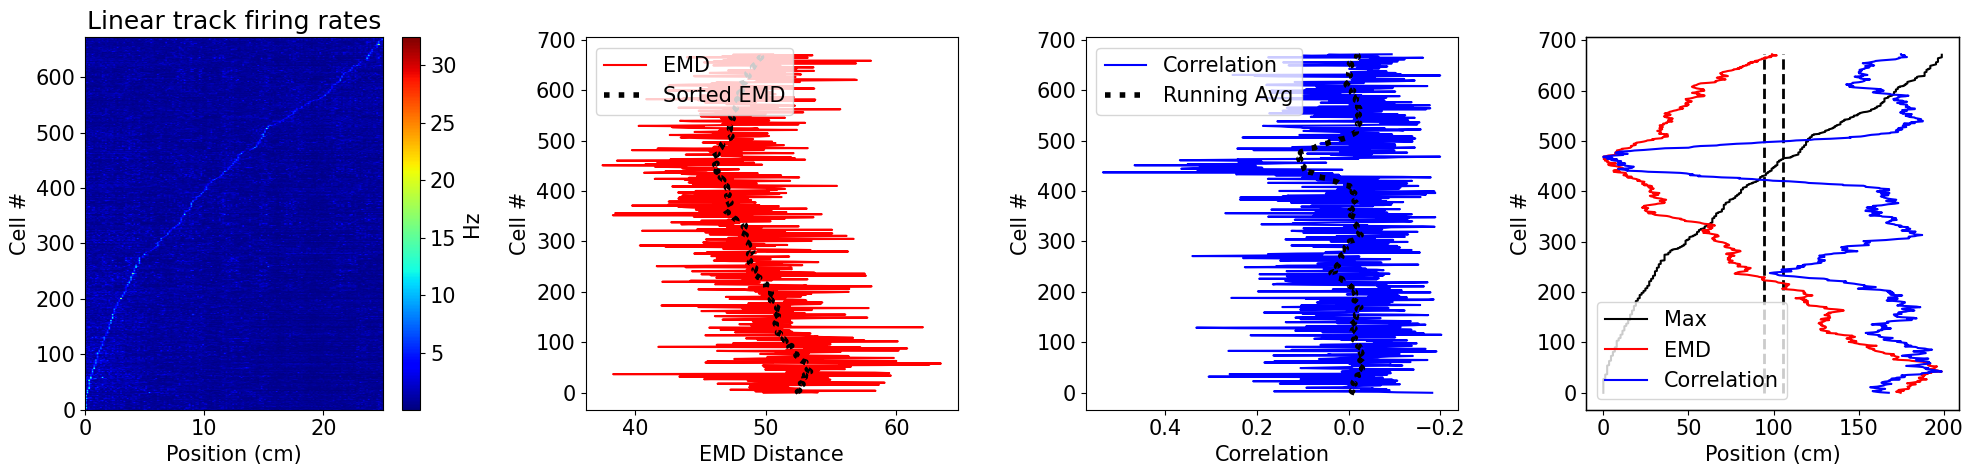

In [5]:
# # For each ROI, fluorescence time courses were normalised to baseline fluorescence by dividing 
# the whole trace by the average intensity in that ROI during the first 100 frames of the recording.
# F = F / np.mean(F[:,:100], axis=1)[:,None]
# # drop rows average F is too large
# keep_F = []
# for f in F:
#     if np.max(f) > 1000 or np.min(f) < -400:
#         pass
#     else:
#         keep_F.append(f)

# keep_F = np.array(keep_F)
# # divide by the baseline, which was defined as the 8th percentile of values in each ~15 second interval
inf_contents = []
keep_spks = []
keep_spks_order = []
max_line = []
keep_spks_unchanged = []
for spk in spks:

    if True:

        if True:
            spk_copy = np.copy(spk)
            frames_to_sum = int(7.5*15)
            total_sums = len(spk) // frames_to_sum
            spk = spk[:total_sums * frames_to_sum].reshape(-1, frames_to_sum)
            spk = np.mean(spk, axis=1)/15
            if np.min(spk) > 0 and np.mean(spk) > 0.1:
                # and np.max(spk) < 1000 and np.mean(spk) > 0.1:
                spk = spk / np.mean(spk)

                keep_spks_unchanged.append(spk_copy)
                keep_spks.append(spk)
                keep_spks_order.append(np.argmax(spk))
                index_at_max = np.argmax(spk)
                position_at_max = index_at_max * 200 / len(spk)
                max_line.append(position_at_max)

keep_spks = np.array(keep_spks)[np.argsort(keep_spks_order)[::-1]]


max_line = np.array(max_line)[np.argsort(keep_spks_order)[::-1]]
reference = np.zeros_like(keep_spks[0])
# reference = np.mean(keep_spks[0])
midpoint = len(reference)//2
# reference_midpoint = np.copy(reference)
# reference_midpoint[midpoint-1:midpoint+1] = 1

ref_start = np.zeros_like(keep_spks[0])
ref_start[0] = 1

# ref_start_narrow = np.zeros_like(keep_spks[0])
# ref_start_narrow[0:5] = 1
from scipy.ndimage import gaussian_filter1d
ref_start_narrow =  gaussian_filter1d(ref_start, sigma=5)
ref_start_narrow = ref_start_narrow / np.mean(ref_start_narrow)


ref_start_wide = np.zeros_like(keep_spks[0])
ref_start_wide[0:10] = 1

ref_end = np.zeros_like(keep_spks[0])
ref_end[midpoint] = 1

# ref_end_narrow = np.zeros_like(keep_spks[0])
# ref_end_narrow[midpoint-2:midpoint+3] = 1
ref_end_narrow = gaussian_filter1d(ref_end, sigma=5/2)
ref_end_narrow = ref_end_narrow / np.mean(ref_end_narrow)

ref_end_wide = np.zeros_like(keep_spks[0])
ref_end_wide[midpoint-5:midpoint+5] = 1

positions = np.arange(0, 200, 200/len(ref_start))
# average of first 10 cells
# avg = np.mean(keep_spks[:10], axis=0)
count = 0
for reference in [ref_start, ref_start_narrow, ref_start_wide, ref_end, ref_end_narrow, ref_end_wide]:
# ref1 = keep_spks[0]
# ref2 = keep_spks[1]
# ref3 = keep_spks[2]

# ref4 = np.mean(keep_spks[:10], axis=0)
# ref5 = np.mean(keep_spks[:100], axis=0)
# ref6 = np.mean(keep_spks[:], axis=0)

# for reference in [ref1, ref2, ref3, ref4, ref5, ref6]:
    reference = reference / np.mean(reference) 
    emds = []
    corrs = []
    from scipy.stats import pearsonr, spearmanr
    from scipy.stats import wasserstein_distance
    count2 = 0
    for spk in keep_spks:

        # first_half = spk[:len(spk)//2]
        # second_half = spk[len(spk)//2:]

        # corrs.append(np.corrcoef(reference, spk)[0,1])

        r, p = pearsonr(reference, spk)
        # ref_unchanged = np.zeros(len(keep_spks_unchanged[count]))
        # ref_unchanged[0] = 1
        # r, p = pearsonr(ref_unchanged, keep_spks_unchanged[count])
        
        # r, p = spearmanr(first_half, second_half)
        corrs.append(r)
        
        # emd = wasserstein_distance(reference, spk, positions, positions)
        emd = wasserstein_distance(positions, positions, reference, spk)
        # emd = wasserstein_distance(first_half, second_half, positions[:len(spk)//2], positions[len(spk)//2:])
        emds.append(emd)
        count2 += 1

    ### convert emd distances to quantiles ###
    # emds = np.array(emds)
    # quantiles = []
    # for emd in emds:
    #     quantiles.append(np.sum(emds <= emd)/len(emds))
    # emds = np.array(quantiles)

    fig = plt.figure(figsize=(20,5))
    
    # make title and axes labels bold
    font = {'weight' : 'bold'}
    plt.rc('font', **font)
    # make tick label font normal weight
    plt.rcParams.update({'font.weight': 'normal'})
    # font size to 
    plt.rcParams.update({'font.size': 15})



    ax = fig.add_subplot(1, 4, 1)
                    
    img = ax.imshow(keep_spks, aspect='auto', cmap='jet', extent=[0, 25, 0, len(keep_spks)])
    ax.set_title('Linear track firing rates')
    # , fontsize=12)

    ax1 = ax
    
    ax.set_ylabel('Cell #')
    # ,fontsize=12)
    ax.set_xlabel('Position (cm)')
    # ,fontsize=12)
    # cbar = plt.colorbar(img, ax=ax, label='dF/F')
    # cbar.set_label('dF/F', fontsize=12)
    cbar = plt.colorbar(img, ax=ax, label='Hz')
    cbar.set_label('Hz')
    # fontsize=12)

    ax = fig.add_subplot(1, 4, 2)
    
    l1 = ax.plot(np.flip(emds), np.arange(0,len(emds)),color='red')
    window_size = int(0.1*len(emds))
    smooth_trace_emd = np.convolve(np.flip(emds), np.ones(window_size)/window_size, mode='valid')
    l2 = ax.plot(smooth_trace_emd, np.arange(0,len(emds),len(emds)/len(smooth_trace_emd)),'k:',lw=4)
    # l2 = ax.plot(np.sort(np.flip(emds)), np.arange(0,len(emds)),'k:',lw=4)
    ax.set_ylabel('Cell #')
    # fontsize=12)
    ax.set_xlabel('EMD Distance')
    # ,fontsize=12)
    # axt2 = ax.twinx().twiny()
    # axt2.set_ylabel('Cell #',fontsize=12)
    # axt2.set_xlabel('Position (cm)',fontsize=12)

    # ax2 = axt2

    # if count >= 3:
    # l3 = axt2.plot(np.flip(max_line), np.arange(0, len(max_line)), color='black')
    #     axt2.set_xlim(axt2.get_xlim()[::-1])
    # else:
    #     l3 = axt2.plot(np.flip(max_line), np.arange(0, len(max_line)), color='black')
        
    # legend_properties = {'size': 12}

    # if count >= 3:
    ax.legend([l1[0], l2[0]], ['EMD', 'Sorted EMD'], loc='upper left')
    # prop=legend_properties)
    # else:
    #     # ax.set_xlim(0)
    #     ax.legend([l1[0], l2[0]], ['EMD', 'Sorted EMD'], loc ='upper left', bbox_to_anchor=(0.1, 1), prop=legend_properties)
    # ax.invert_xaxis()
    ax = fig.add_subplot(1, 4, 3)
    l1 = ax.plot(np.flip(corrs), np.arange(0,len(corrs)),color='blue')
    window_size = int(0.1*len(corrs))
    smooth_trace_corr = np.convolve(corrs, np.ones(window_size)/window_size, mode='valid')
    smooth_trace_corr = np.flip(smooth_trace_corr)
    l2 = ax.plot(smooth_trace_corr, np.arange(0,len(corrs),len(corrs)/len(smooth_trace_corr)),'k:',lw=4)

    # flip x axis
    ax.invert_xaxis()
    ax.set_ylabel('Cell #')
    # fontsize=12)
    ax.set_xlabel('Correlation')
    # fontsize=12)
    # axt2 = ax.twinx().twiny()
    # axt2.set_ylabel('Cell #',fontsize=12)
    # axt2.set_xlabel('Position (cm)',fontsize=12)
    # if count >= 3:
    # l3 = axt2.plot(np.flip(max_line), np.arange(0, len(max_line)), color='black')
    #     axt2.set_xlim(axt2.get_xlim()[::-1])
    # else:
    #     l3 = axt2.plot(np.flip(max_line), np.arange(0, len(max_line)), color='black')
        
    # legend_properties = {'size': 12}

    # if count >= 3:
    ax.legend([l1[0], l2[0]], ['Correlation', 'Running Avg'], loc='upper left')
    # prop=legend_properties)
    # else:
    #     ax.legend([l1[0], l2[0]], ['Correlation', 'Running Avg'], loc ='upper left', bbox_to_anchor=(0.1, 1), prop=legend_properties) 
    
    # ax3 = axt2

    ax = fig.add_subplot(1, 4, 4)
    lbl_max = ax.plot(np.flip(max_line), np.arange(0, len(max_line)), color='black')
    # if count == 5:
    #     max_line_copy = np.copy(max_line)
    #     idx = np.where(max_line_copy <= midpoint)[0]
    #     max_line_copy[idx] = midpoint - max_line_copy[idx]
    #     max_line_copy[idx] += midpoint
    #     ax.plot(np.flip(max_line_copy), np.arange(0, len(max_line)), color='black', linestyle=':', linewidth=2)      

    ax_emd = ax.twinx().twiny()
    lbl_emd = ax_emd.plot(smooth_trace_emd, np.arange(0,len(emds),len(emds)/len(smooth_trace_emd)), color='red')
    # hide x and y ticks
    ax_emd.set_xticks([])
    ax_emd.set_yticks([])
    ax_corr = ax.twinx().twiny()
    lbl_corr = ax_corr.plot(smooth_trace_corr, np.arange(0,len(corrs),len(corrs)/len(smooth_trace_corr)), color='blue')
    # hide x and y ticks
    ax_corr.set_xticks([])
    ax_corr.set_yticks([])
    ax_corr.invert_xaxis()
    # ax_emd.invert_xaxis()

    if count == 1:
        ax_again = ax.twinx().twiny()
        toplot = ref_start_narrow.reshape(-1,1)
        # toplot[toplot< 0.001] = np.nan
        ax_again.imshow(toplot.T, cmap='jet', aspect='auto', alpha=0.5)
        ax_again.set_xticks([])
        ax_again.set_yticks([])
        # remove axis completely
    elif count == 4:
        ax_again = ax.twinx().twiny()
        toplot = ref_end_narrow.reshape(-1,1)
        # toplot[toplot< 0.001] = np.nan
        ax_again.imshow(toplot.T, cmap='jet', aspect='auto', alpha=0.5)
        ax_again.set_xticks([])
        ax_again.set_yticks([])
        # remove axis completely
        


    ax.set_ylabel('Cell #')
    ax.set_xlabel('Position (cm)')

    for ax in [ax,]:
        if count == 0:
            ax.vlines(positions[0], 0, len(keep_spks), color='k', linestyle='--', lw=2)
        # elif count == 1:
        #     ax.vlines(positions[0], 0, len(keep_spks), color='k', linestyle='--', lw=2)
        #     ax.vlines(positions[5], 0, len(keep_spks), color='k', linestyle='--', lw=2)
        elif count == 2:
            ax.vlines(positions[0], 0, len(keep_spks), color='k', linestyle='--', lw=2)
            ax.vlines(positions[10], 0, len(keep_spks), color='k', linestyle='--', lw=2)
        elif count == 3:
            ax.vlines(positions[midpoint], 0, len(keep_spks), color='k', linestyle='--', lw=2)
        # elif count == 4:
        #     ax.vlines(positions[midpoint-2], 0, len(keep_spks), color='k', linestyle='--', lw=2)
        #     ax.vlines(positions[midpoint+3], 0, len(keep_spks), color='k', linestyle='--', lw=2)

        elif count == 5:
            ax.vlines(positions[midpoint-5], 0, len(keep_spks), color='k', linestyle='--', lw=2)
            ax.vlines(positions[midpoint+5], 0, len(keep_spks), color='k', linestyle='--', lw=2)
    # legend
    # legend_properties = {'size': 12}
    if count >= 3:
        ax.legend([lbl_max[0], lbl_emd[0], lbl_corr[0]], ['Max', 'EMD', 'Correlation'], loc='lower left')
        # prop=legend_properties)
    else:
        ax.legend([lbl_max[0], lbl_emd[0], lbl_corr[0]], ['Max', 'EMD', 'Correlation'], loc ='upper left', bbox_to_anchor=(0.1, 1))
        # prop=legend_properties)

            

    fig.tight_layout()
    plt.show()

    fnme = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\rd-figs\figs\spks_" + str(count) + ".pdf"
    fig.savefig(fnme, dpi=1080)

    count += 1

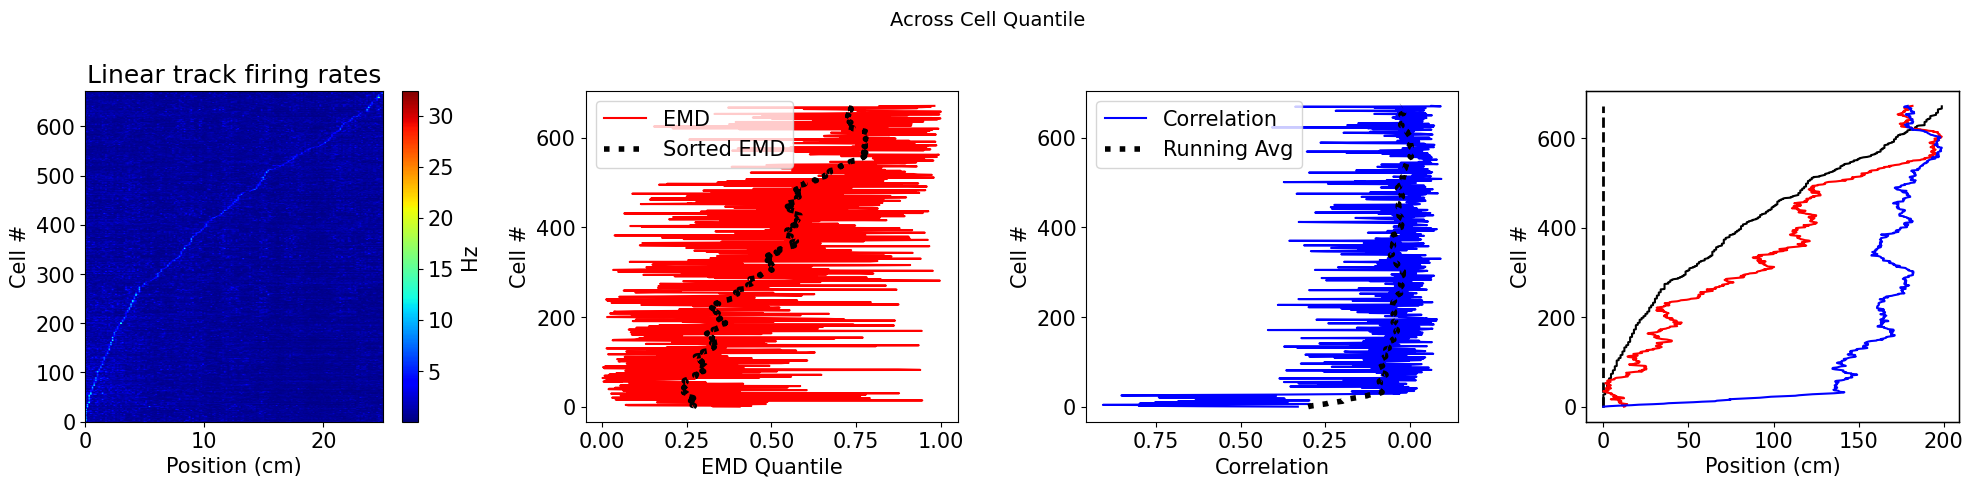

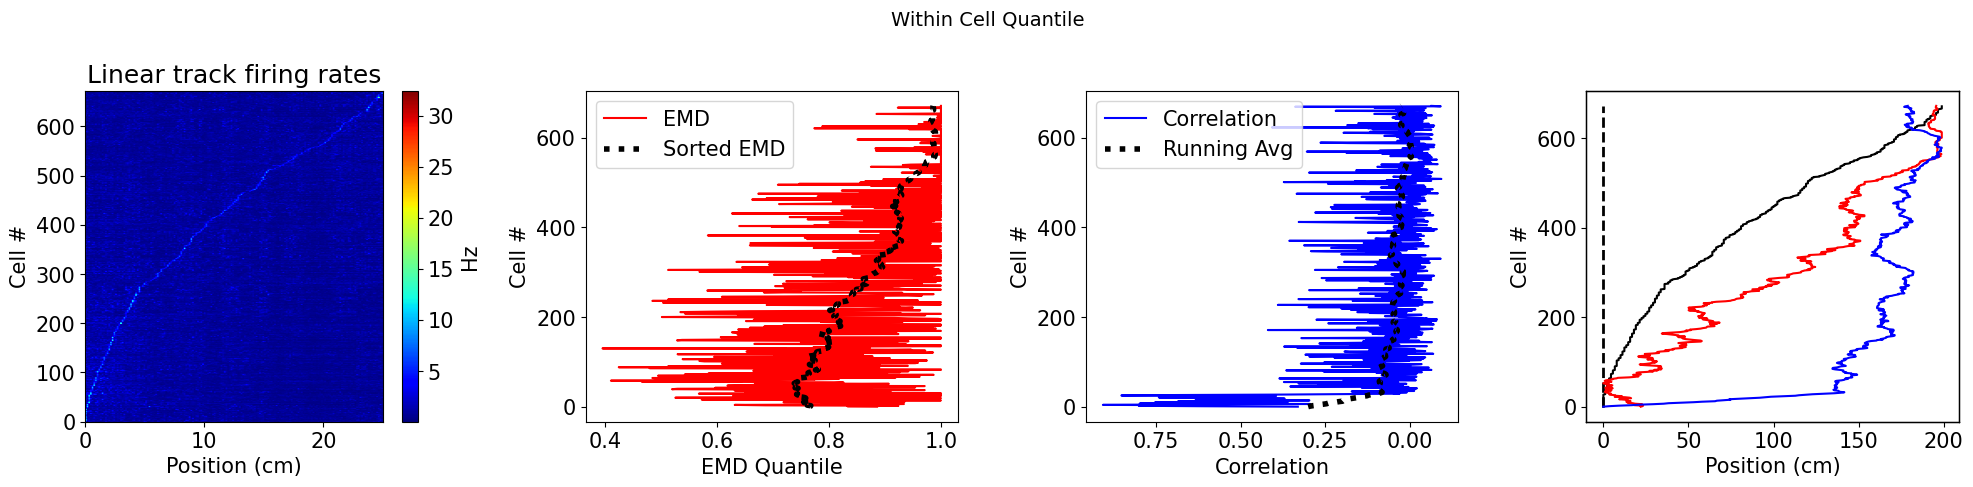

In [6]:
from scipy.stats import pearsonr, spearmanr
from scipy.stats import wasserstein_distance
from scipy.ndimage import gaussian_filter1d

inf_contents = []
keep_spks = []
keep_spks_order = []
max_line = []
keep_spks_unchanged = []
for spk in spks:
    if True:
        if True:
            spk_copy = np.copy(spk)
            frames_to_sum = int(7.5*15)
            total_sums = len(spk) // frames_to_sum
            spk = spk[:total_sums * frames_to_sum].reshape(-1, frames_to_sum)
            spk = np.mean(spk, axis=1)/15
            if np.min(spk) > 0 and np.mean(spk) > 0.1:
                # and np.max(spk) < 1000 and np.mean(spk) > 0.1:
                spk = spk / np.mean(spk)
                # inf_contents.append(inf_content)
                keep_spks_unchanged.append(spk_copy)
                keep_spks.append(spk)
                keep_spks_order.append(np.argmax(spk))
                index_at_max = np.argmax(spk)
                position_at_max = index_at_max * 200 / len(spk)
                max_line.append(position_at_max)

keep_spks = np.array(keep_spks)[np.argsort(keep_spks_order)[::-1]]

max_line = np.array(max_line)[np.argsort(keep_spks_order)[::-1]]
reference = np.zeros_like(keep_spks[0])
midpoint = len(reference)//2

ref_start = np.zeros_like(keep_spks[0])
ref_start[0] = 1

ref_start_narrow =  gaussian_filter1d(ref_start, sigma=5)
ref_start_narrow = ref_start_narrow / np.mean(ref_start_narrow)

ref_start_wide = np.zeros_like(keep_spks[0])
ref_start_wide[0:10] = 1

ref_end = np.zeros_like(keep_spks[0])
ref_end[midpoint] = 1

# ref_end_narrow = np.zeros_like(keep_spks[0])
# ref_end_narrow[midpoint-2:midpoint+3] = 1
ref_end_narrow = gaussian_filter1d(ref_end, sigma=5/2)
ref_end_narrow = ref_end_narrow / np.mean(ref_end_narrow)

ref_end_wide = np.zeros_like(keep_spks[0])
ref_end_wide[midpoint-5:midpoint+5] = 1

positions = np.arange(0, 200, 200/len(ref_start))

count = 0
for reference in [ref_start, ref_start]:

    reference = reference / np.mean(reference) 
    emds = []
    corrs = []
    emd_inputs = []

    count2 = 0
    for spk in keep_spks:
        r, p = pearsonr(reference, spk)
        corrs.append(r)
        emd = wasserstein_distance(positions, positions, reference, spk)
        emds.append(emd)
        emd_inputs.append([positions, reference, spk])
        count2 += 1

    quantiles = []
    if count == 0:
        # quantiles relative to other cells
        for emd in emds:
            quantiles.append(np.sum(emds <= emd)/len(emds))
    elif count == 1:
        # quantiles relative to random position sampling
        for i in range(len(emds)):
            emd = emds[i]
            positions = emd_inputs[i][0]
            reference = emd_inputs[i][1]
            spk = emd_inputs[i][2]
            mxid = np.argmax(spk)
            pos_use = np.copy(positions)
            pos_use[mxid-7:mxid+7] = np.nan
            pos_use = pos_use[~np.isnan(pos_use)]
            random_positions = np.random.choice(pos_use, size=1000, replace=True)
            rand_emds = []
            for rand_pos in random_positions:
                closest_idx = np.argmin(np.abs(positions - rand_pos))
                reference = np.zeros_like(positions)
                reference[closest_idx] = 1
                rand_emd = wasserstein_distance(positions, positions, reference, spk)
                rand_emds.append(rand_emd)
            quantiles.append(np.sum(rand_emds <= emd)/len(rand_emds))
    # elif count == 2:
    #     # quantiles relative to mismatched cells. If we 

    emds = np.array(quantiles)


    fig = plt.figure(figsize=(20,5))

        
    # make title and axes labels bold
    font = {'weight' : 'bold'}
    plt.rc('font', **font)
    # make tick label font normal weight
    plt.rcParams.update({'font.weight': 'normal'})
    plt.rcParams.update({'font.size': 15})



    ax = fig.add_subplot(1, 4, 1)
                    
    img = ax.imshow(keep_spks, aspect='auto', cmap='jet', extent=[0, 25, 0, len(keep_spks)])
    ax.set_title('Linear track firing rates')
    # fontsize=12)

    ax1 = ax
    
    ax.set_ylabel('Cell #')
    # ,fontsize=12)
    ax.set_xlabel('Position (cm)')
    # ,fontsize=12)
    cbar = plt.colorbar(img, ax=ax, label='Hz')
    cbar.set_label('Hz')
    # , fontsize=12)

    ax = fig.add_subplot(1, 4, 2)
    
    l1 = ax.plot(np.flip(emds), np.arange(0,len(emds)),color='red')
    window_size = int(0.1*len(emds))
    smooth_trace_emd = np.convolve(np.flip(emds), np.ones(window_size)/window_size, mode='valid')
    l2 = ax.plot(smooth_trace_emd, np.arange(0,len(emds),len(emds)/len(smooth_trace_emd)),'k:',lw=4)
    ax.set_ylabel('Cell #')
    # ,fontsize=12)
    ax.set_xlabel('EMD Quantile')
    # ,fontsize=12)

    # legend_properties = {'size': 12}

    ax.legend([l1[0], l2[0]], ['EMD', 'Sorted EMD'], loc='upper left')
    # prop=legend_properties)
    ax = fig.add_subplot(1, 4, 3)
    l1 = ax.plot(np.flip(corrs), np.arange(0,len(corrs)),color='blue')
    window_size = int(0.1*len(corrs))
    smooth_trace_corr = np.convolve(corrs, np.ones(window_size)/window_size, mode='valid')
    smooth_trace_corr = np.flip(smooth_trace_corr)
    l2 = ax.plot(smooth_trace_corr, np.arange(0,len(corrs),len(corrs)/len(smooth_trace_corr)),'k:',lw=4)

    # flip x axis
    ax.invert_xaxis()
    ax.set_ylabel('Cell #')
    # ,fontsize=12)
    ax.set_xlabel('Correlation')
    # ,fontsize=12)

    # legend_properties = {'size': 12}

    ax.legend([l1[0], l2[0]], ['Correlation', 'Running Avg'], loc='upper left')
    # , prop=legend_properties)
    
    ax = fig.add_subplot(1, 4, 4)
    lbl_max = ax.plot(np.flip(max_line), np.arange(0, len(max_line)), color='black')

    ax_emd = ax.twinx().twiny()
    lbl_emd = ax_emd.plot(smooth_trace_emd, np.arange(0,len(emds),len(emds)/len(smooth_trace_emd)), color='red')
    # hide x and y ticks
    ax_emd.set_xticks([])
    ax_emd.set_yticks([])
    ax_corr = ax.twinx().twiny()
    lbl_corr = ax_corr.plot(smooth_trace_corr, np.arange(0,len(corrs),len(corrs)/len(smooth_trace_corr)), color='blue')
    # hide x and y ticks
    ax_corr.set_xticks([])
    ax_corr.set_yticks([])
    ax_corr.invert_xaxis()
    # ax_emd.invert_xaxis()

    ax.set_ylabel('Cell #')
    # ,fontsize=12)
    ax.set_xlabel('Position (cm)')
    # ,fontsize=12)

    for ax in [ax,]:
        ax.vlines(positions[0], 0, len(keep_spks), color='k', linestyle='--', lw=2)

    if count == 0:
        fig.suptitle('Across Cell Quantile',fontsize=14)
    elif count == 1:
        fig.suptitle('Within Cell Quantile', fontsize=14)

    fig.tight_layout()
    plt.show()

    # savefig
    fnme = r"C:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\rd-figs\figs\quantiles_" + str(count) + ".pdf"
    fig.savefig(fnme, dpi=1080)

    count += 1

In [7]:
# from scipy.stats import pearsonr, spearmanr
# from scipy.stats import wasserstein_distance
# from scipy.ndimage import gaussian_filter1d

# inf_contents = []
# keep_spks = []
# keep_spks_order = []
# max_line = []
# keep_spks_unchanged = []
# for spk in spks:
#     if True:
#         if True:
#             spk_copy = np.copy(spk)
#             frames_to_sum = int(7.5*15)
#             total_sums = len(spk) // frames_to_sum
#             spk = spk[:total_sums * frames_to_sum].reshape(-1, frames_to_sum)
#             spk = np.mean(spk, axis=1)/15
#             if np.min(spk) > 0 and np.mean(spk) > 0.1:
#                 # and np.max(spk) < 1000 and np.mean(spk) > 0.1:
#                 spk = spk / np.mean(spk)
#                 # inf_contents.append(inf_content)
#                 keep_spks_unchanged.append(spk_copy)
#                 keep_spks.append(spk)
#                 keep_spks_order.append(np.argmax(spk))
#                 index_at_max = np.argmax(spk)
#                 position_at_max = index_at_max * 200 / len(spk)
#                 max_line.append(position_at_max)

# keep_spks = np.array(keep_spks)[np.argsort(keep_spks_order)[::-1]]

# max_line = np.array(max_line)[np.argsort(keep_spks_order)[::-1]]
# reference = np.zeros_like(keep_spks[0])
# midpoint = len(reference)//2

# ref_start = np.zeros_like(keep_spks[0])
# ref_start[0] = 1

# ref_start_narrow =  gaussian_filter1d(ref_start, sigma=5)
# ref_start_narrow = ref_start_narrow / np.mean(ref_start_narrow)

# ref_start_wide = np.zeros_like(keep_spks[0])
# ref_start_wide[0:10] = 1

# ref_end = np.zeros_like(keep_spks[0])
# ref_end[midpoint] = 1

# # ref_end_narrow = np.zeros_like(keep_spks[0])
# # ref_end_narrow[midpoint-2:midpoint+3] = 1
# ref_end_narrow = gaussian_filter1d(ref_end, sigma=5/2)
# ref_end_narrow = ref_end_narrow / np.mean(ref_end_narrow)

# ref_end_wide = np.zeros_like(keep_spks[0])
# ref_end_wide[midpoint-5:midpoint+5] = 1

# positions = np.arange(0, 200, 200/len(ref_start))
# field_window_half = 3
# count = 0
# for reference in [ref_start, ref_start]:

#     reference = reference / np.mean(reference) 
#     emds = []
#     corrs = []
#     emd_inputs = []

#     count2 = 0
#     for spk in keep_spks:
#         argm = np.argmax(spk)
#         old_ref = np.copy(reference)
#         ref_manipulate = np.copy(reference)
#         spk_manipulate = np.copy(spk)
#         # pos_manipulate = np.copy(positions)
#         old_spk = np.copy(spk)

#         if argm-field_window_half < 0:
#             ref_manipulate[:argm+field_window_half] = np.nan
#             # positions[:argm+field_window_half] = np.nan
#             spk_manipulate[:argm+field_window_half] = np.nan
#         elif argm+field_window_half > len(spk):
#             ref_manipulate[argm-field_window_half:] = np.nan
#             # positions[argm-field_window_half:] = np.nan
#             spk_manipulate[argm-field_window_half:] = np.nan
#         else:
#             assert argm-field_window_half >= 0 
#             assert argm+field_window_half <= len(spk)
#             ref_manipulate[:argm-field_window_half] = np.nan
#             ref_manipulate[argm+field_window_half:] = np.nan
#             # positions[:argm-field_window_half] = np.nan
#             # positions[argm+field_window_half:] = np.nan
#             spk_manipulate[:argm-field_window_half] = np.nan
#             spk_manipulate[argm+field_window_half:] = np.nan

#         # old_spk[spk != spk] = 0
#         old_spk = np.copy(spk_manipulate)

#         ref_manipulate = ref_manipulate[~np.isnan(old_spk)]
#         spk_manipulate = spk_manipulate[~np.isnan(old_spk)]

#         r, p = pearsonr(ref_manipulate, spk_manipulate) # with nan not 0 on spk
#         # r, p = pearsonr(old_ref, spk_manipulate)
#         corrs.append(r)
#         emd = wasserstein_distance(positions[old_spk == old_spk], positions, old_spk[old_spk == old_spk], old_ref)
#         emds.append(emd)
#         emd_inputs.append([positions, old_ref, old_spk])
#         count2 += 1

#     quantiles = []
#     if count == 0:
#         # quantiles relative to other cells
#         for emd in emds:
#             quantiles.append(np.sum(emds <= emd)/len(emds))
#     elif count == 1:
#         # quantiles relative to random position sampling
#         for i in range(len(emds)):
#             emd = emds[i]
#             positions = emd_inputs[i][0]
#             reference = emd_inputs[i][1]
#             spk = emd_inputs[i][2]
#             mxid = np.argmax(spk)
#             # pos_use = np.copy(positions)
#             # pos_use[mxid-7:mxid+7] = np.nan
#             # pos_use = pos_use[~np.isnan(pos_use)]
#             random_positions = np.random.choice(positions, size=1000, replace=True)
#             lower = positions[mxid-7]
#             upper = positions[mxid+7]
#             # drop random positions that are within this range
#             random_positions = random_positions[(random_positions < lower) | (random_positions > upper)]
#             rand_emds = []
#             for rand_pos in random_positions:
#                 closest_idx = np.argmin(np.abs(positions - rand_pos))
#                 reference = np.zeros_like(positions)
#                 reference[closest_idx] = 1
#                 rand_emd = wasserstein_distance(positions, positions, reference, spk)
#                 rand_emds.append(rand_emd)
#             quantiles.append(np.sum(rand_emds <= emd)/len(rand_emds))
#     # elif count == 2:
#     #     # quantiles relative to mismatched cells. If we 

#     emds = np.array(quantiles)


#     fig = plt.figure(figsize=(25,5))

#     ax = fig.add_subplot(1, 4, 1)
                    
#     img = ax.imshow(keep_spks, aspect='auto', cmap='jet', extent=[0, 25, 0, len(keep_spks)])
#     ax.set_title('Linear track firing rates', fontsize=12)

#     ax1 = ax
    
#     ax.set_ylabel('Cell #',fontsize=12)
#     ax.set_xlabel('Position (cm)',fontsize=12)
#     cbar = plt.colorbar(img, ax=ax, label='Hz')
#     cbar.set_label('Hz', fontsize=12)

#     ax = fig.add_subplot(1, 4, 2)
    
#     l1 = ax.plot(np.flip(emds), np.arange(0,len(emds)),color='red')
#     window_size = int(0.1*len(emds))
#     smooth_trace_emd = np.convolve(np.flip(emds), np.ones(window_size)/window_size, mode='valid')
#     l2 = ax.plot(smooth_trace_emd, np.arange(0,len(emds),len(emds)/len(smooth_trace_emd)),'k:',lw=4)
#     ax.set_ylabel('Cell #',fontsize=12)
#     ax.set_xlabel('EMD Quantile',fontsize=12)

#     legend_properties = {'size': 12}

#     ax.legend([l1[0], l2[0]], ['EMD', 'Sorted EMD'], loc='upper left', prop=legend_properties)
#     ax = fig.add_subplot(1, 4, 3)
#     l1 = ax.plot(np.flip(corrs), np.arange(0,len(corrs)),color='blue')
#     window_size = int(0.1*len(corrs))
#     smooth_trace_corr = np.convolve(corrs, np.ones(window_size)/window_size, mode='valid')
#     smooth_trace_corr = np.flip(smooth_trace_corr)
#     l2 = ax.plot(smooth_trace_corr, np.arange(0,len(corrs),len(corrs)/len(smooth_trace_corr)),'k:',lw=4)

#     # flip x axis
#     ax.invert_xaxis()
#     ax.set_ylabel('Cell #',fontsize=12)
#     ax.set_xlabel('Correlation',fontsize=12)

#     legend_properties = {'size': 12}

#     ax.legend([l1[0], l2[0]], ['Correlation', 'Running Avg'], loc='upper left', prop=legend_properties)
    
#     ax = fig.add_subplot(1, 4, 4)
#     lbl_max = ax.plot(np.flip(max_line), np.arange(0, len(max_line)), color='black')

#     ax_emd = ax.twinx().twiny()
#     lbl_emd = ax_emd.plot(smooth_trace_emd, np.arange(0,len(emds),len(emds)/len(smooth_trace_emd)), color='red')
#     # hide x and y ticks
#     ax_emd.set_xticks([])
#     ax_emd.set_yticks([])
#     ax_corr = ax.twinx().twiny()
#     lbl_corr = ax_corr.plot(smooth_trace_corr, np.arange(0,len(corrs),len(corrs)/len(smooth_trace_corr)), color='blue')
#     # hide x and y ticks
#     ax_corr.set_xticks([])
#     ax_corr.set_yticks([])
#     ax_corr.invert_xaxis()
#     # ax_emd.invert_xaxis()

#     ax.set_ylabel('Cell #',fontsize=12)
#     ax.set_xlabel('Position (cm)',fontsize=12)

#     for ax in [ax,]:
#         ax.vlines(positions[0], 0, len(keep_spks), color='k', linestyle='--', lw=2)

#     if count == 0:
#         fig.suptitle('Across Cell Quantile - Field', fontsize=16)
#     elif count == 1:
#         fig.suptitle('Within Cell Quantile - Field', fontsize=16)

#     fig.tight_layout()
#     plt.show()

#     count += 1

In [16]:
os.chdir('..')
os.chdir('..')
os.chdir('..')
%ls

 Volume in drive C is Windows
 Volume Serial Number is A041-80F0

 Directory of c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit

12/28/2023  07:00 AM    <DIR>          .
12/28/2023  07:00 AM    <DIR>          ..
08/25/2022  04:03 PM               378 .gitattributes
08/25/2022  04:03 PM               140 .gitignore
08/29/2022  11:30 AM    <DIR>          .pytest_cache
09/02/2022  09:39 AM    <DIR>          .vscode
03/20/2023  02:05 PM    <DIR>          _prototypes
02/15/2023  08:41 PM    <DIR>          All_PRISM_Sessions_iter_1
02/17/2023  12:57 PM    <DIR>          All_PRISM_Sessions_iter_2
02/17/2023  01:26 PM    <DIR>          All_PRISM_Sessions_iter_3
02/17/2023  02:10 PM    <DIR>          All_PRISM_Sessions_iter_4
02/21/2023  03:14 PM    <DIR>          All_PRISM_Sessions_iter_5
02/21/2023  07:04 PM    <DIR>          All_PRISM_Sessions_iter_6
11/01/2023  02:07 PM               995 B6vsANT_quantile_indiv_beta_binary.csv
11/01/2023  02:06 PM               99

(64, 2) (64,) (8, 8)


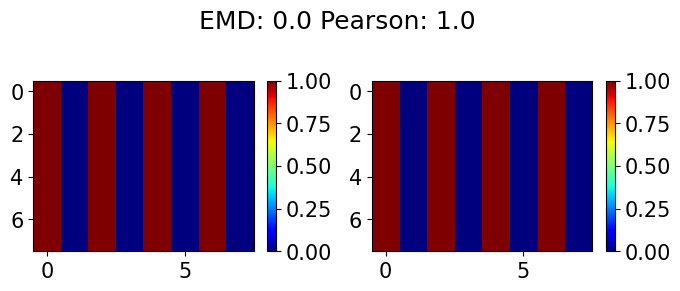

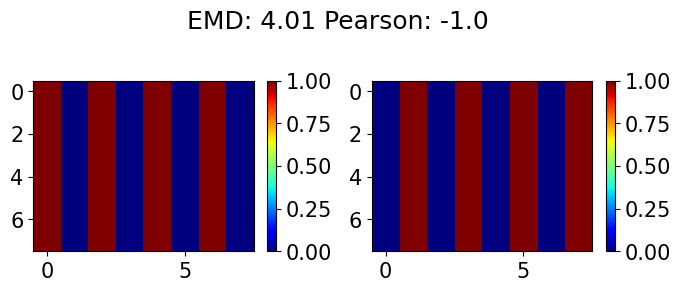

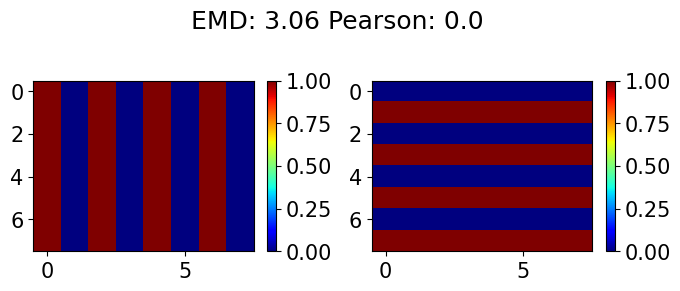

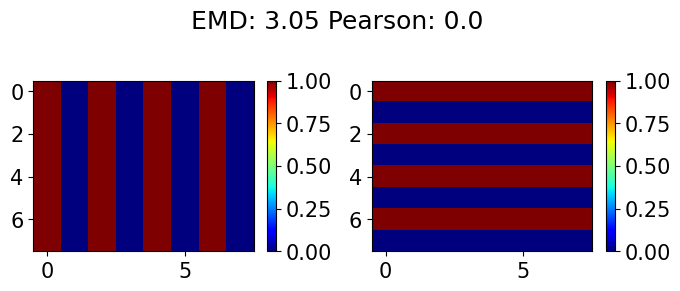

In [18]:
from _prototypes.cell_remapping.src.wasserstein_distance import sliced_wasserstein, single_point_wasserstein, pot_sliced_wasserstein

# make grid of alternating columns of 0s and 1s
sze = 8

g1 = np.zeros((sze, sze))
for i in range(sze):
    if i % 2 == 0:
        g1[:,i] = 1

g2 = np.zeros((sze, sze))
for i in range(sze):
    if i % 2 != 0:
        g2[:,i] = 1

# 2d positions
positions = []
for i in range(sze):
    for j in range(sze):
        positions.append([i,j])
print(np.array(positions).shape, g1.flatten().shape, g2.shape)

emd = pot_sliced_wasserstein( positions, positions, g1.flatten(), g1.flatten(), n_projections=10**4)
pearson = np.corrcoef(g1.flatten(), g1.flatten())[0,1]
emd = round(emd, 2)
pearson = round(pearson, 2)

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(1, 2, 1)
img = ax.imshow(g1, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)
ax = fig.add_subplot(1, 2, 2)
img = ax.imshow(g1, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)

fig.suptitle('EMD: ' + str(emd) + ' Pearson: ' + str(pearson))

fig.tight_layout()
plt.show()

emd = pot_sliced_wasserstein( positions, positions, g1.flatten(), g2.flatten(), n_projections=10**4)
pearson = np.corrcoef(g1.flatten(), g2.flatten())[0,1]
emd = round(emd, 2)
pearson = round(pearson, 2)

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(1, 2, 1)
img = ax.imshow(g1, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)
ax = fig.add_subplot(1, 2, 2)
img = ax.imshow(g2, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)

fig.suptitle('EMD: ' + str(emd) + ' Pearson: ' + str(pearson))

fig.tight_layout()
plt.show()

# rotate g1
g1_rot = np.rot90(g1)
emd = pot_sliced_wasserstein( positions, positions, g1_rot.flatten(), g1.flatten(), n_projections=10**4)
pearson = np.corrcoef(g1_rot.flatten(), g1.flatten())[0,1]
emd = round(emd, 2)
pearson = round(pearson, 17)

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(1, 2, 1)
img = ax.imshow(g1, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)
ax = fig.add_subplot(1, 2, 2)
img = ax.imshow(g1_rot, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)

fig.suptitle('EMD: ' + str(emd) + ' Pearson: ' + str(pearson))

fig.tight_layout()
plt.show()

# rotate g2
g2_rot = np.rot90(g2)
emd = pot_sliced_wasserstein( positions, positions, g2_rot.flatten(), g1.flatten(), n_projections=10**4)
pearson = np.corrcoef(g2_rot.flatten(), g1.flatten())[0,1]
emd = round(emd, 2)
pearson = round(pearson, 17)

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(1, 2, 1)
img = ax.imshow(g1, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)
ax = fig.add_subplot(1, 2, 2)
img = ax.imshow(g2_rot, aspect='auto', cmap='jet')
plt.colorbar(img, ax=ax)

fig.suptitle('EMD: ' + str(emd) + ' Pearson: ' + str(pearson))

fig.tight_layout()
    